# Churn - Feature Engineering

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import os
for d in ['orig','data','output']: os.makedirs(d, exist_ok=True)
    
DEBUG = False
SEED = 72

In [2]:
# utility function for typesetting percentages
display_fraction = lambda n,d: (n/d*100, n, d)

## Load and Prepare the Data 

I have made a slight change of naming convention which will simply code below - and also avoid mistakes in lab sessions when I rerun cells out of order to demo parts of the code.   Rather than using __df__ to store the full dataset I will use __df_all__, and use __df__ as an alias for various dataset as needed - see [Feature Engineering](#Feature_Engineering). So will try to follow naming convention:

 * __df__ alias for various datasets (treat as a link a tmp variable, more later). 
 * __df_all__ full dataset after loading and prepped (columns renamed, value recoded).
 * __df_model__ dataset with target and a subset of the original attributes that may appear in model or be used to construct other attributes.
 * __df_train__ dataset 
 * __df_test__ dataset 

 


In [3]:
df_churn = pd.read_csv("data/churn.csv")
print("Churn", df_churn.shape)
df_states = pd.read_csv("data/states.csv")
print("States", df_states.shape)

df_all = df_churn.merge(df_states, on="State")

message = (" * Data set consists of %d cases (rows) with %s features (cols) and a single target."  
% (df_all.shape[0], df_all.shape[1]-1))
display(Markdown(message))
df_all.head(1)

Churn (3333, 22)
States (52, 4)


 * Data set consists of 3333 cases (rows) with 24 features (cols) and a single target.

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn,Area,Latitude,Longitude,Name
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,0,382,39.011902,-98.484246,Kansas


## Pre-Processing Data

In [4]:
target = "Churn"
features = df_all.columns.tolist()
for c in [target, "Phone", "State", "Name"]:
    if c in features: features.remove(c) 

# keep copy of origonal features for reporting later
original_features = features[:]

df_model = df_all.loc[:, features + [target]]

### Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.40, random_state=SEED)
df_train.shape, df_test.shape

((1999, 22), (1334, 22))

## Feature_Engineering 

Features engineering and selection decision is carried out on __df_train__ ONLY, but resulting operations should be applied to both __df_train__ and __df_test__. The simplest way to do this (without repeating code) is to apply operations to __df_model__ and repeat the train/test split USING THE SAME SEED.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [6]:
my_query = df_train.query('CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
my_query.head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Area,Latitude,Longitude,Churn
26,167,415,0,0,0,131.6,120,22.37,211.3,96,17.96,168.3,97,7.57,11.1,4,3.00,4,409,39.011902,-98.484246,1
1489,159,415,0,1,23,153.6,93,26.11,216.9,88,18.44,161.3,91,7.26,12.6,3,3.40,2,394,33.836081,-81.163725,0
3222,107,408,0,0,0,103.4,94,17.58,189.3,125,16.09,227.2,125,10.22,14.4,3,3.89,1,339,41.603221,-73.087749,0
1261,57,415,0,0,0,161.0,113,27.37,208.0,134,17.68,208.1,81,9.36,8.4,4,2.27,3,403,31.968599,-99.901813,0
38,120,510,0,0,0,158.0,110,26.86,197.0,103,16.75,154.9,132,6.97,10.0,5,2.70,1,392,39.011902,-98.484246,0


In [7]:
df_model["Cranky_Triskaidekaphobias"] = df_model.apply (lambda row: (row.CustServ_Calls>0 
            and row.Day_Calls!=13 and row.Eve_Calls!=13 
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

In [8]:
# test generated feature to ensure has sufficient variability
df_model.Cranky_Triskaidekaphobias.value_counts()

True     2626
False     707
Name: Cranky_Triskaidekaphobias, dtype: int64

### New Feature - ????

### New Feature - ????

### New Feature - ????

### New Feature - ????

### New Feature - ????

## Model Selection

We are not going to focus on model selection today, so just going to use a few different types of classifiers to see the impact of different features.

In [9]:
models = []

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models.append( {"name": "NB", "ref": GaussianNB()} )

# k-nearest neighbor 
from sklearn.neighbors import KNeighborsClassifier
models.append( {"name": "KNN", "ref": KNeighborsClassifier()} )

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models.append( {"name": "LogisticRegression", "ref": LogisticRegression(solver="lbfgs")} )

# Support Vector Machines
from sklearn.svm import SVC
models.append( {"name": "SVC", "ref": SVC(gamma="scale")} )

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models.append( {"name": "DT (pruned=4)", "ref": DecisionTreeClassifier(criterion='entropy', max_depth=4)} )

print("Models:")
for model in models:
    print(f"    {model['name']:30} {model['ref']}")

    
def train_models():
    for model in models:
    
        scores = cross_val_score(model["ref"], X_train, y_train, scoring='f1', cv=10)
        model['score_mean'] = scores.mean()
        model['score_std'] = scores.std()
        print ("\nModel %s" % model["name"])
        print ("\tCV scores %s" % [f"{s:.4f}" for s in scores])
        print (f"\tmean={model['score_mean']:.2%} std={model['score_std']:.4f}")
    
    opt = [model for model in models if model['score_mean']==max(model['score_mean'] for model in models)]
    print (f"\nBest Performing Model {model['name']} with mean={model['score_mean']:.2%}" )

Models:
    NB                             GaussianNB()
    KNN                            KNeighborsClassifier()
    LogisticRegression             LogisticRegression()
    SVC                            SVC()
    DT (pruned=4)                  DecisionTreeClassifier(criterion='entropy', max_depth=4)


## Model Training

In [10]:
print (df_model.columns.values)

['Account_Length' 'Area_Code' 'Intl_Plan' 'VMail_Plan' 'VMail_Message'
 'Day_Mins' 'Day_Calls' 'Day_Charge' 'Eve_Mins' 'Eve_Calls' 'Eve_Charge'
 'Night_Mins' 'Night_Calls' 'Night_Charge' 'Intl_Mins' 'Intl_Calls'
 'Intl_Charge' 'CustServ_Calls' 'Area' 'Latitude' 'Longitude' 'Churn'
 'Cranky_Triskaidekaphobias']


### Train-Test Split

REPEAT train/test split from above so that both data subsets have the modified feature set.

In [11]:
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.40, random_state=SEED)
features = df_model.columns.tolist()
for c in [target, "Phone", "State", "Name", "Longitude", "Latitude"]: 
    if c in features: features.remove(c)

print(features)

['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Area', 'Cranky_Triskaidekaphobias']


In [12]:
df_model.loc[:,features].head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Area,Cranky_Triskaidekaphobias
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,382,True
1,70,408,0,0,0,232.1,122,39.46,292.3,112,24.85,201.2,112,9.05,0.0,0,0.00,3,411,True
2,92,408,1,0,0,62.6,111,10.64,180.6,126,15.35,221.7,80,9.98,10.4,2,2.81,1,386,True
3,137,408,0,0,0,205.9,88,35.00,209.3,86,17.79,289.9,84,13.05,14.5,4,3.92,2,352,True
4,132,415,0,0,0,83.4,110,14.18,232.2,137,19.74,146.7,114,6.60,7.6,5,2.05,1,369,True


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.Churn.values

### Evaluation

We used accuracy metric last week. 
Given the unbalanced dataset, other metrics are more appropriate. Recall which focus on identifying the churn cases is a good option. However, we will go with f1 score which is the harmonic mean of precision and recall.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, classification_report

### Training - First Iteration

In [15]:
train_models()


Model NB
	CV scores ['0.5333', '0.4727', '0.4194', '0.5926', '0.4364', '0.4615', '0.5902', '0.6032', '0.4483', '0.3929']
	mean=49.50% std=0.0743

Model KNN
	CV scores ['0.2857', '0.4103', '0.5000', '0.3333', '0.4737', '0.3333', '0.4390', '0.5957', '0.3590', '0.2162']
	mean=39.46% std=0.1061

Model LogisticRegression
	CV scores ['0.4545', '0.1905', '0.1860', '0.3077', '0.1667', '0.2632', '0.4545', '0.4681', '0.2439', '0.1538']
	mean=28.89% std=0.1198

Model SVC
	CV scores ['0.5500', '0.5778', '0.5455', '0.6512', '0.5909', '0.6190', '0.6818', '0.6222', '0.6522', '0.5000']
	mean=59.91% std=0.0538

Model DT (pruned=4)
	CV scores ['0.6000', '0.6809', '0.6667', '0.5957', '0.6522', '0.6923', '0.6538', '0.5778', '0.6531', '0.4762']
	mean=62.49% std=0.0613

Best Performing Model DT (pruned=4) with mean=62.49%


### Feature Selection

Next we are going to try to reduce the number of features using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) a recursive feature elimination with cross-validation function.

RFECV needs a classifier that returns information about feature importance either through a `coef_` attribute or through a `feature_importances_` attribute. 
Of our models given above will work, only `LogisticRegression` and `DT` provide this information


In [16]:
print("Number of features starting:", len(features))

Number of features starting: 20


In [17]:
# list of our modules that can be used with RFECV
suitable_models = [model for model in models if model['name'].split()[0] in ['LogisticRegression','DT'] ]

Optimal number of features : 20


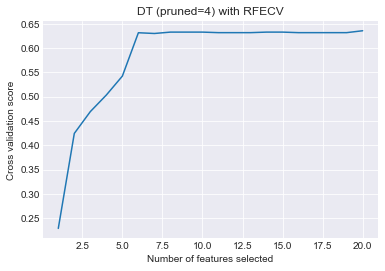

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

model = models[4]

rfecv = RFECV(estimator=model["ref"], step=1, cv=StratifiedKFold(2), scoring="f1")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{model['name']} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [19]:
# list of features selected
features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['Account_Length',
 'Area_Code',
 'Intl_Plan',
 'VMail_Plan',
 'VMail_Message',
 'Day_Mins',
 'Day_Calls',
 'Day_Charge',
 'Eve_Mins',
 'Eve_Calls',
 'Eve_Charge',
 'Night_Mins',
 'Night_Calls',
 'Night_Charge',
 'Intl_Mins',
 'Intl_Calls',
 'Intl_Charge',
 'CustServ_Calls',
 'Area',
 'Cranky_Triskaidekaphobias']

### Training - After Feature Selection

In [20]:
display(df_model.loc[:, features_selected + [target]].head(1))

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,features_selected].values)
y_test = df_test.Churn.values

train_models()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Area,Cranky_Triskaidekaphobias,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,382,True,0



Model NB
	CV scores ['0.5333', '0.4727', '0.4194', '0.5926', '0.4364', '0.4615', '0.5902', '0.6032', '0.4483', '0.3929']
	mean=49.50% std=0.0743

Model KNN
	CV scores ['0.2857', '0.4103', '0.5000', '0.3333', '0.4737', '0.3333', '0.4390', '0.5957', '0.3590', '0.2162']
	mean=39.46% std=0.1061

Model LogisticRegression
	CV scores ['0.4545', '0.1905', '0.1860', '0.3077', '0.1667', '0.2632', '0.4545', '0.4681', '0.2439', '0.1538']
	mean=28.89% std=0.1198

Model SVC
	CV scores ['0.5500', '0.5778', '0.5455', '0.6512', '0.5909', '0.6190', '0.6818', '0.6222', '0.6522', '0.5000']
	mean=59.91% std=0.0538

Model DT (pruned=4)
	CV scores ['0.6000', '0.6809', '0.6667', '0.5957', '0.6522', '0.6923', '0.6538', '0.5778', '0.6531', '0.4762']
	mean=62.49% std=0.0613

Best Performing Model DT (pruned=4) with mean=62.49%
